This notebook is meant to demonstrate that when the `dem-stitcher` merges DEM tiles, we do not modify the georeferencing/CRS of the area (unless a new resolution is specified). Frequently, if you fix an extent (as in rasterio), resampling is done so that a new origin is selected so that it is a multiple of the desired resolution (as determined by the extented or the "target aligned pixel" option). In the case of `dem-stitcher`, we try to not do any resampling, be it in windowed reading or when merging, we want the smallest rectangular area *containing* the extent so that we literally have a subset of pixels from the original tiles.

Thus, our test is as follows, we utilize `dem-stitcher` to obtain a DEM raster and compare it to the tiles used to generate them.

In [1]:
from dem_stitcher import stitch_dem
from dem_stitcher.stitcher import get_dem_tiles
import rasterio
import matplotlib.pyplot as plt
from rasterio import plot
import geopandas as gpd
from shapely.geometry import box
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np
from numpy.testing import assert_array_equal

# Select bounds and get relevant tiles

Select which bounds you want for your test. You can add more.

In [2]:
# Within a Los Angeles tile
la_bounds = [-118.8, 34.6, -118.5, 34.8]

# Within a few Aleutian tiles
aleutian_bounds = [-167.2,53.4,-166.8, 53.8] 

# Select the area that is desired or add your own
bounds = aleutian_bounds

Get the relevant tile urls.

In [3]:
df_request_bounds = gpd.GeoDataFrame(geometry=[box(*bounds)],
                                     crs=CRS.from_epsg(4326))

df = get_dem_tiles(bounds, 'glo_30')
df

,geometry,tile_id,url,dem_name
0,"POLYGON ((-168.00021 53.00014, -168.00021 54.0...",Copernicus_DSM_COG_10_N53_00_W168_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/Co...,glo_30
1,"POLYGON ((-167.00021 53.00014, -167.00021 54.0...",Copernicus_DSM_COG_10_N53_00_W167_00_DEM,https://copernicus-dem-30m.s3.amazonaws.com/Co...,glo_30


We can read glo directly from the open s3 bucket.

# Read the Tile

In [4]:
tile_url = df.url.tolist()[0]
with rasterio.open(tile_url) as ds:
    X_tile = ds.read(1)
    p_tile = ds.profile

We will plot the extent the first tile for illustration.

<AxesSubplot:>

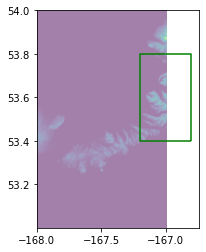

In [5]:
fig, ax = plt.subplots()

plot.show(X_tile, transform=p_tile['transform'], zorder=1, alpha=.5, ax=ax)
df_request_bounds.boundary.plot(ax=ax, color='green', zorder=2)

# Use `dem-stitcher` to get a subset

We are going to get the subset of DEM tiles located in the green box above.

In [6]:
X_subset, p_subset = stitch_dem(bounds, 
                                'glo_30', 
                                # The tiles are pixel centered by default
                                dst_area_or_point='Point',
                                # Let's not transform them
                                dst_ellipsoidal_height=False\
                               )

Reading glo_30 Datasets: 100%|█| 2/2 [00:02<00:00,  1.09s/it


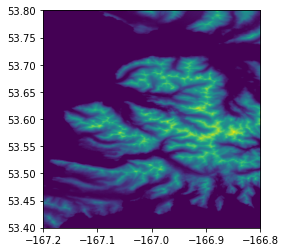

<AxesSubplot:>

In [7]:
plot.show(X_subset, transform=p_subset['transform'])

# Comparison between the tile and the subset

To compare the original DEM tile and the subset raster we obtained we have to do some resampling. So we are going to reproject back into the tile reference frame. The goal is that this resampling is still "preserving" the actual tile.

In [8]:
X_subset_r, _ = reproject_arr_to_match_profile(X_subset, 
                                               p_subset, 
                                               p_tile,
                                               # In QGIS, the pixels will look co-located
                                               resampling='nearest'
                                              )

X_subset_r = X_subset_r[0, ...]

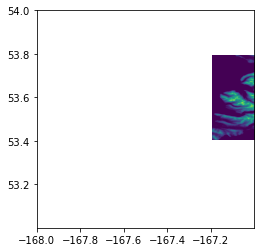

<AxesSubplot:>

In [9]:
plot.show(X_subset_r, transform=p_tile['transform'])

## The comparsions

In [10]:
np.nansum(X_subset_r - X_tile)

0.0

In [11]:
mask = np.isnan(X_subset_r)

data_tile_masked = X_tile[~mask]
data_subset = X_subset_r[~mask]
assert_array_equal(data_tile_masked, data_subset)